The Machine Learning Capstone project examines a data set from the OKCupid dating app.


In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

#Create your df here:
df = pd.read_csv("profiles.csv")

print(df.columns,'\n') #get familiar with the data set

print(df.diet.value_counts(),'\n')
print(df.drugs.value_counts(),'\n')
print(df.smokes.value_counts())


Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object') 

mostly anything        16585
anything                6183
strictly anything       5113
mostly vegetarian       3444
mostly other            1007
strictly vegetarian      875
vegetarian               667
strictly other           452
mostly vegan             338
other                    331
strictly vegan           228
vegan                    136
mostly kosher             86
mostly halal              48
strictly kosher           18
strictly halal            18
halal                     11
kosher                    11
Name: diet, dtype: int64 

never        37724
sometimes     7732
often          410
Name: drugs, d

First areas to question are what is meant by 'diet' and 'status'. Also, how broad of an income demographic is represented.

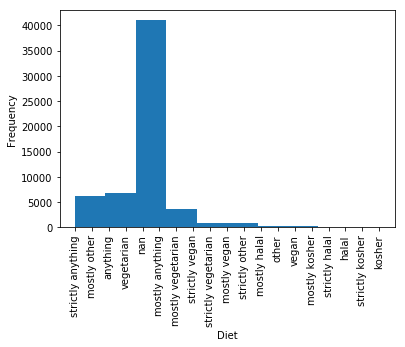

In [52]:

plt.hist(list(df.diet.values))
plt.xlabel("Diet")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


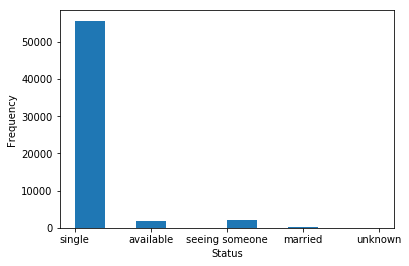

In [53]:
plt.hist(list(df.status.values))
plt.xlabel("Status")
plt.ylabel("Frequency")
plt.show()

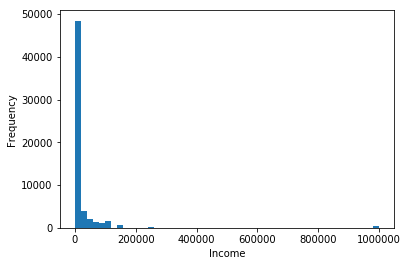

In [54]:
plt.hist(list(df.income.values), bins=50)
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()


A lot of zero answers for the Income, so that data is probably not very complete; suspect people don't want to say.

Formulate some questions to be answered:

Can we infer a positive or negative personality from the essay answer wordings then relate to lifestyle; diet, drinks, drugs, and smokes?


Augment the drinks, drugs, and smokes data to numerical.


In [55]:
# This diet mapping might be enhanced later by defining principles for strictness
diet_mapping = {
  "mostly anything": 0,
  "anything": 1,
  "strictly anything": 2,
  "mostly vegetarian": 3,
  "mostly other": 4,
  "strictly vegetarian": 6,
  "vegetarian": 5,
  "strictly other": 7,
  "mostly vegan": 8,
  "other": 9,
  "strictly vegan": 11,
  "vegan": 10,
  "mostly kosher": 12,
  "mostly halal": 13,
  "strictly halal": 14,
  "strictly kosher": 15,
  "kosher": 16,
  "halal": 17
  }
df["diet_code"] = df.diet.map(diet_mapping)

drink_mapping = {"not at all": 0, "rarely": 1, "socially": 2, "often": 3, "very often": 4, "desperately": 5}
df["drinks_code"] = df.drinks.map(drink_mapping)

drug_mapping = {"never": 0, "sometimes" : 1, "often" : 3}
df["drugs_code"] = df.drugs.map(drug_mapping)

smoke_mapping = {"no": 0, "trying to quit": 1, "sometimes": 2, "when drinking": 3, "yes": 4}
df["smokes_code"] = df.smokes.map(smoke_mapping)


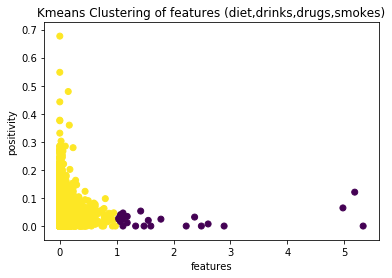


Linear Regression Results
Train Score: 0.005137425980599186
Test Score: 0.005486654000600888
[('diet_code', -0.020258744342442098), ('smokes_code', -0.005817919689083491), ('drinks_code', 0.0030633766942830378), ('drugs_code', -0.001691002607273498)]


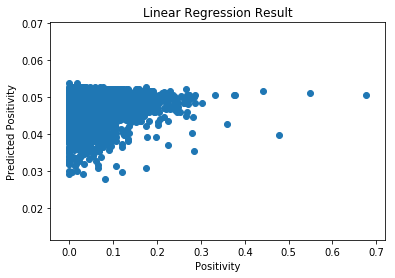


KNeighbor Regressor Results
Train Score: -0.3362499195635129
Test Score: -0.3361986480988135


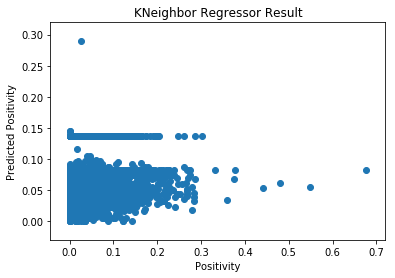

In [56]:
# Create data removing NaNs and combining the essay answers 
essay_cols = ["essay0","essay1","essay2","essay3","essay4","essay5","essay6","essay7","essay8","essay9"]

# Removing the NaNs
all_essays = df[essay_cols].replace(np.nan, ' ', regex=True)
# Combining the essays
all_essays = all_essays[essay_cols].apply(lambda x: ' '.join(x), axis=1)

# Use positive word analysis to develop a proportional score (enhance this capability later, if successful!)
positive_words = ['laugh','love','good','friend','confident','enjoy','joy','positive']

all_positive = []
for i in range(len(all_essays)):
    positive_count = 0
    for word in positive_words:
        positive_count += all_essays[i].count(word)
    all_positive.append(100 * positive_count / len(all_essays[i]))

series = pd.Series(all_positive)
df['positive_count'] = series.values


# Normalize the data set we want to use

feature_data = df[['diet_code','drinks_code','drugs_code','smokes_code','positive_count']].replace(np.nan, -1, regex=True)

x = feature_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

feature_data = pd.DataFrame(x_scaled, columns=feature_data.columns)


#split the data into train and test
x = feature_data[['diet_code','drinks_code','drugs_code','smokes_code']]
y = feature_data['positive_count']
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)

# Categorize features using Kmeans Clustering
model = KMeans(init='random', n_clusters=2)
# Merge features for clustering analysis
features = X_test['diet_code'] * X_test['drinks_code'] * X_test['drugs_code'] * X_test['smokes_code'] / (0.5)**3
results = model.fit_predict(list(zip(features,y_test)))

plt.scatter(features, y_test, c=results, alpha=1)
plt.title('Kmeans Clustering of features (diet,drinks,drugs,smokes)')
plt.xlabel('features')
plt.ylabel('positivity')
plt.show()



# Predict positivity with Multiple Linear Regression to the positive_count
model = LinearRegression()
model.fit(X_train, y_train)

# Analyze accuracy...
print('\nLinear Regression Results')
print('Train Score:', model.score(X_train,y_train))
print('Test Score:', model.score(X_test,y_test))
print(sorted(list(zip(feature_data.columns,model.coef_)),key = lambda x: abs(x[1]),reverse=True))

y_predicted = model.predict(X_test)

plt.scatter(y_test,y_predicted)
plt.title('Linear Regression Result')
plt.xlabel('Positivity')
plt.ylabel('Predicted Positivity')
plt.show()

# Predict positivity with K-Nearest Neighbors Regression

classifier = KNeighborsRegressor(n_neighbors = 5, weights="distance")
classifier.fit(X_train, y_train)

print('\nKNeighbor Regressor Results')
print('Train Score:', classifier.score(X_train,y_train))
print('Test Score:', classifier.score(X_test,y_test))
#print(sorted(list(zip(feature_data.columns,classifier.coef_)),key = lambda x: abs(x[1]),reverse=True))

y_predicted = classifier.predict(X_test)

plt.scatter(y_test,y_predicted)
plt.title('KNeighbor Regressor Result')
plt.xlabel('Positivity')
plt.ylabel('Predicted Positivity')
plt.show()

# Analyze accuracy...

